In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, UpSampling2D, Conv2DTranspose

In [ ]:
def table_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation = 'relu', name = 'conv7_table')(x)
  x = UpSampling2D((2,2), name = '2xconv7_table')(x)
  x = Concatenate()([x,vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv7_table')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides= 2 , padding = 'same', name = 'table_mask')(x)
  return x

In [ ]:
def column_decoder(x, vgg19_pool3, vgg19_pool4):
  x = Conv2D(512, (1,1), activation='relu', name = 'conv7_column')(x)
  x = Dropout(0.8)(x)
  x = Conv2D(512, (1,1), activation='relu', name = 'conv8_column')(x)
  x = UpSampling2D((2,2), name = '2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool4])
  x = UpSampling2D((2,2), name = '2x_pool4_2xconv8_column')(x)
  x = Concatenate()([x, vgg19_pool3])
  x = UpSampling2D(size=(2,2))(x)
  x = UpSampling2D(size=(2,2))(x)
  x =  Conv2DTranspose(3,3, strides=2, padding = 'same', name = 'column_mask')(x)
  return x

In [ ]:
input = Input((256,256,3), name = 'input')
vgg_19 = tf.keras.applications.VGG19(include_top=False, weights = 'imagenet', input_tensor=input)
print(f'VGG19 ouput shape :{vgg_19.output_shape}')
vgg19_pool3 = vgg_19.get_layer('block3_pool').output
print(f'VGG19 pool3 layer output shape : {vgg19_pool3.shape}')
vgg19_pool4 = vgg_19.get_layer('block4_pool').output
print(f'VGG19 pool4 layer output shape : {vgg19_pool4.shape}')

x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv1')(vgg_19.output)
x = Dropout(0.8)(x)
x = Conv2D(512, (1,1), activation='relu', name = 'block6_conv2')(x)
x = Dropout(0.8)(x)
print(f'Shape of encoder output: {x.shape}')

VGG19 ouput shape :(None, 8, 8, 512)
VGG19 pool3 layer output shape : (None, 32, 32, 256)
VGG19 pool4 layer output shape : (None, 16, 16, 512)
Shape of encoder output: (None, 8, 8, 512)


In [ ]:
table_decoder_output = table_decoder(x, vgg19_pool3, vgg19_pool4)
column_decoder_output = column_decoder(x, vgg19_pool3, vgg19_pool4)

In [ ]:
model =  Model(inputs = input, outputs = [table_decoder_output, column_decoder_output], name = 'tablenet')

In [ ]:
model.summary()

Model: "tablenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

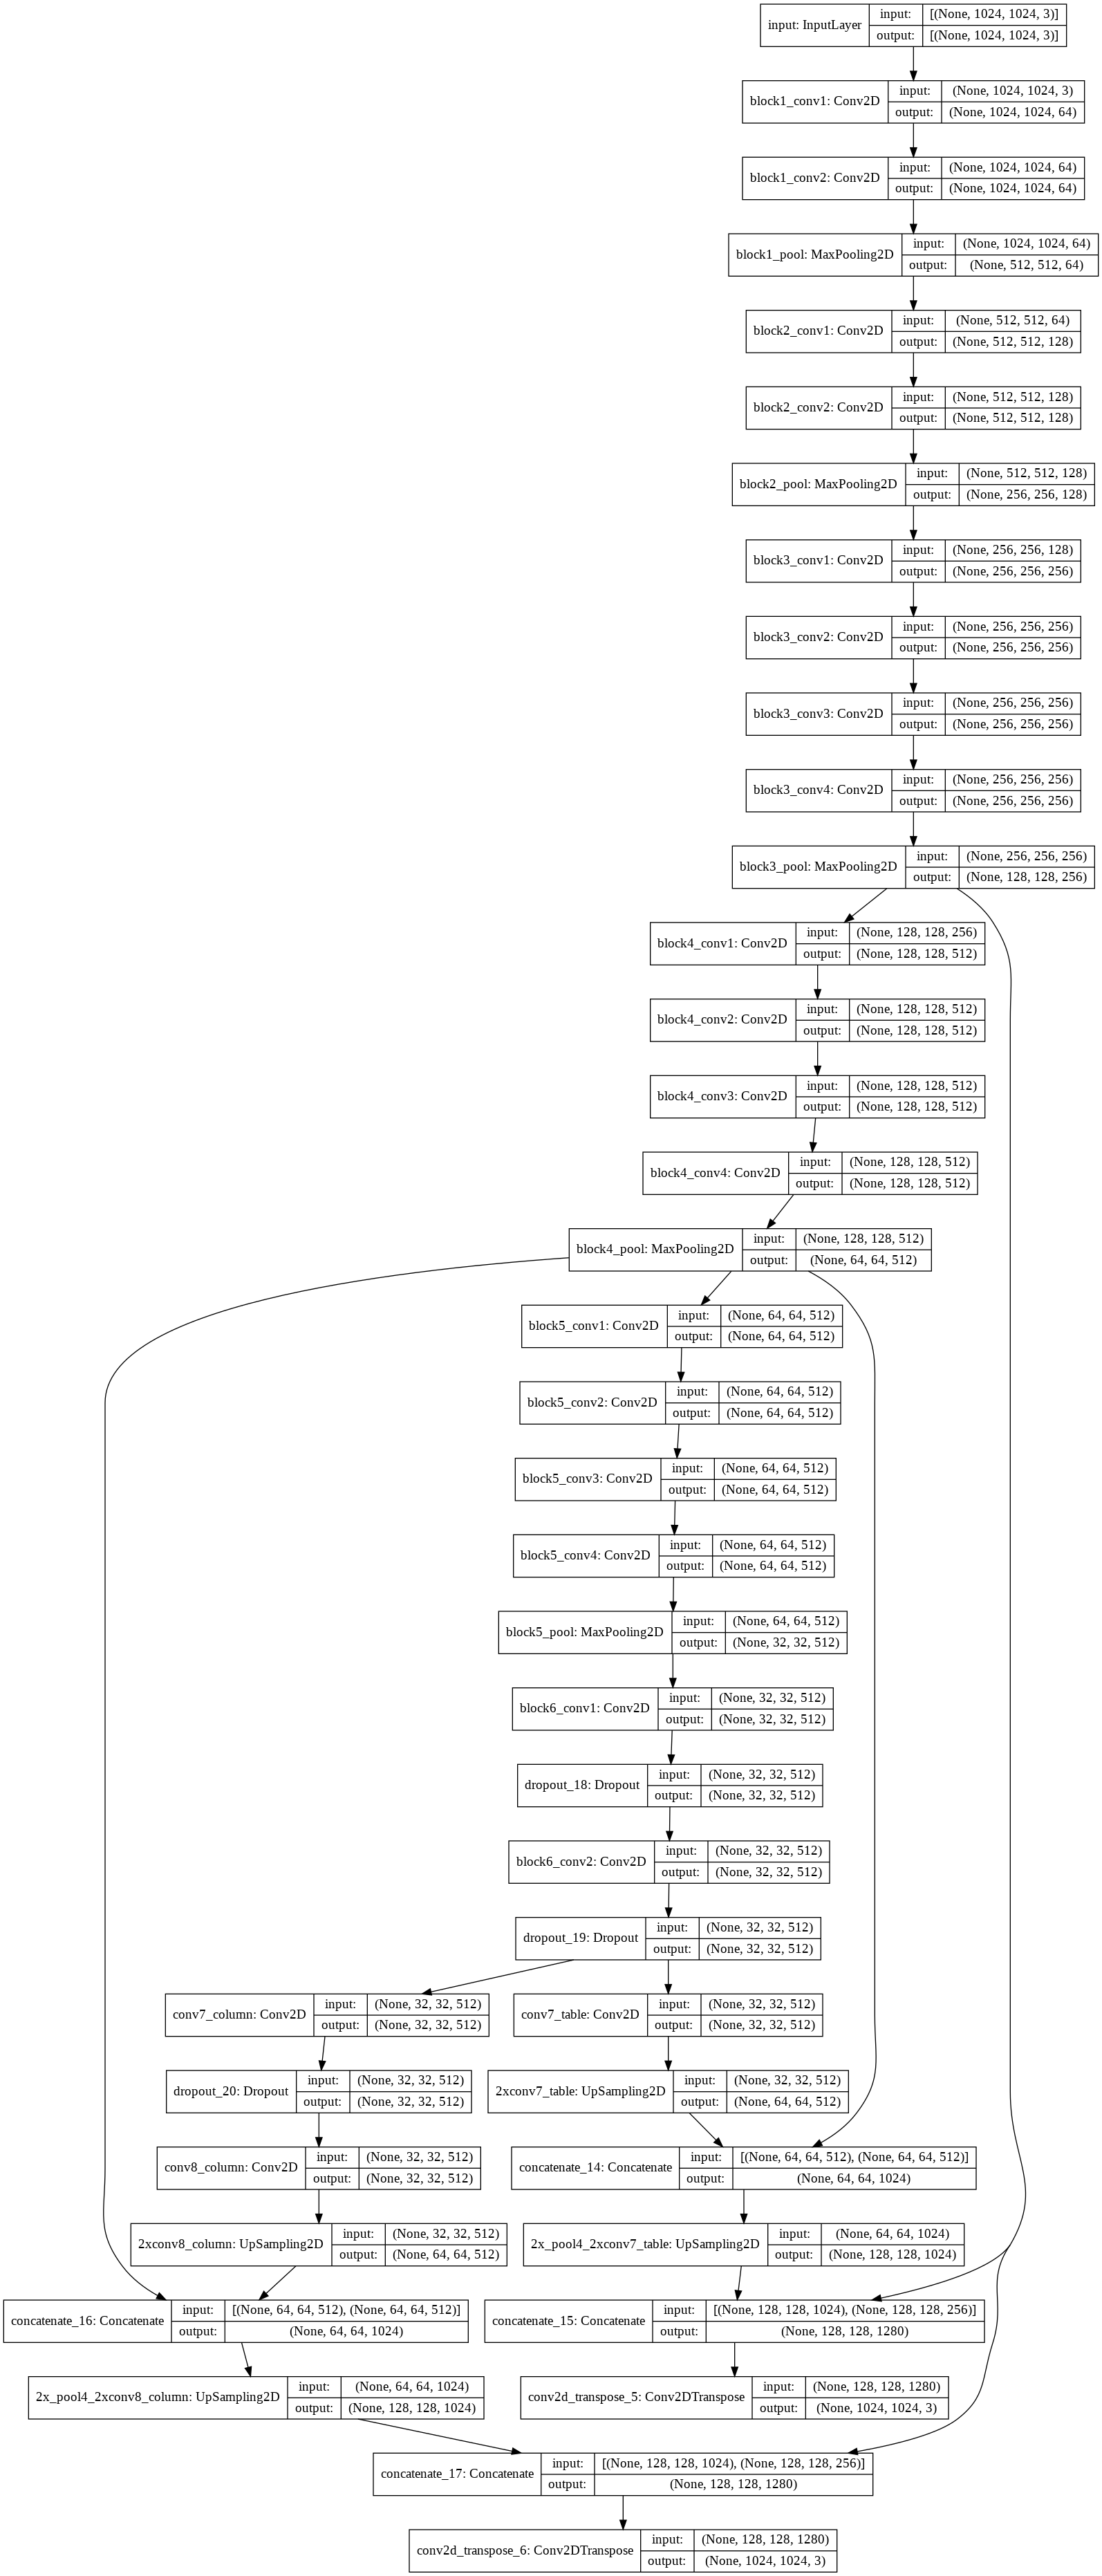

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)